# Explainable AI with FastAI

Below is the code used in the conference paper titled "Classification of kidney abnormalities using deep learning with explainable AI" with the DOI: 10.1109/WiDS-PSU57071.2023.00037

In [ ]:
#Installing and importing fast AI library and other libraries for model training
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from google.colab import drive
import splitfolders
from fastbook import *
from fastai.vision.all import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 KB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 95.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 45.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 111.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 80.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 21.2 MB/s eta 0:00:00
Mounted at /content/gdrive


In [ ]:
# Since this code was done on google collab, the data was extracted from gdrive hence this connection to access the image files
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install split_folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# splitting the images into 3 sets
splitfolders.ratio("add path to your dataset", output="./dataset", seed=1337, ratio=(.8, .2), group_prefix=None)

Copying files: 8737 files [04:42, 30.87 files/s] 


In [ ]:
# Editing the path for each set of data
path = Path('./dataset')
train_fnames = get_image_files(path/"train")

In [ ]:
train_fnames[0]

Path('dataset/train/Stone/Stone- (1137).jpg')

In [ ]:
# Using basic data augmentation to solve data imbalance
augs = [RandomResizedCropGPU(size=224, min_scale=0.75), Rotate(), Zoom()]
dblock = DataBlock(blocks=(ImageBlock(cls=PILImage), CategoryBlock),
                   splitter=RandomSplitter(valid_pct=0.2, seed=23),
                   get_y=parent_label,
                   item_tfms=Resize(512, method="squish"),
                   batch_tfms=augs,
                   )

dls = dblock.dataloaders(train_fnames)

In [ ]:
# print number of classes and length of train and valid datasets
dls.c, len(dls.train_ds), len(dls.valid_ds)

(3, 6091, 1522)

In [ ]:
# Print data classes
dls.vocab

['Normal', 'Stone', 'Tumor']

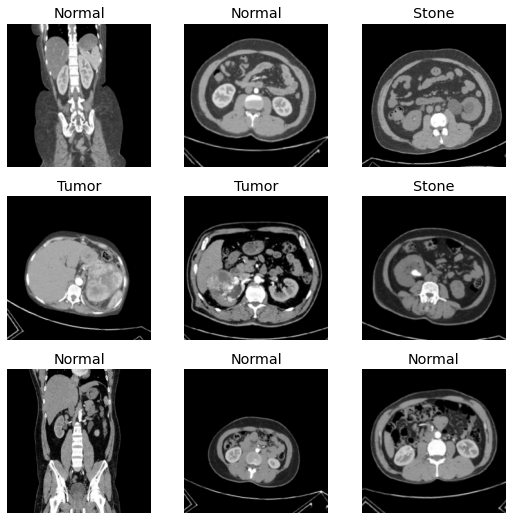

In [ ]:
# Show images and its classes
dls.show_batch()

In [ ]:
# Import pretrained model 
model = nn.Sequential(create_body(xresnet50(), pretrained=False),create_head(nf=2048, n_out=3))
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)



In [ ]:
# Train the model after adding the early stopping function
learn.fit_one_cycle(20,1e-2,cbs=[EarlyStoppingCallback
                                 (monitor='accuracy', min_delta=0.01, patience=3),
                                 SaveModelCallback(monitor='accuracy', min_delta=0.01)])


Better model found at epoch 0 with accuracy value: 0.40998685359954834.
Better model found at epoch 1 with accuracy value: 0.7562417984008789.
Better model found at epoch 2 with accuracy value: 0.9415243268013.
No improvement since epoch 2: early stopping


In [ ]:
# Save Best Model for later use
learn.save('add path to save model')

Path('/content/drive/MyDrive/MPhil PhD/Kidney images CT/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/kidneyabnormalities.pth')

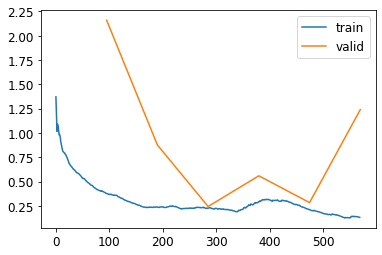

In [ ]:
# Model traing and validation curve
learn.recorder.plot_loss(skip_start=0, with_valid=True)

In [ ]:
all_files= get_image_files(path)

# Evaluating model performance using the unseen test set

In [ ]:
dblock = DataBlock(blocks=(ImageBlock(cls=PILImage), CategoryBlock),
                   splitter=GrandparentSplitter(train_name='train', valid_name='val'),
                   get_y=parent_label,
                   item_tfms=Resize(512, method="squish"),
                   )

dls_test = dblock.dataloaders(all_files)

In [ ]:
print("Number of examples in testing:", len(dls_test.valid_ds))

Number of examples in testing: 1914


In [ ]:
model = nn.Sequential(create_body(xresnet50(), pretrained=False),create_head(nf=2048, n_out=3))

In [ ]:
learn1 = Learner(dls_test, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy).load('use saved path for model')

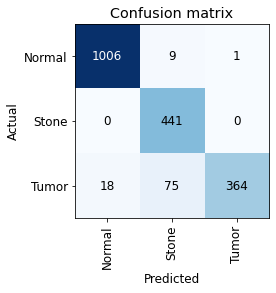

In [ ]:
interp = ClassificationInterpretation.from_learner(learn1)
interp.plot_confusion_matrix()

In [ ]:
interp.print_classification_report()

              precision    recall  f1-score   support

      Normal       0.98      0.99      0.99      1016
       Stone       0.84      1.00      0.91       441
       Tumor       1.00      0.80      0.89       457

    accuracy                           0.95      1914
   macro avg       0.94      0.93      0.93      1914
weighted avg       0.95      0.95      0.95      1914



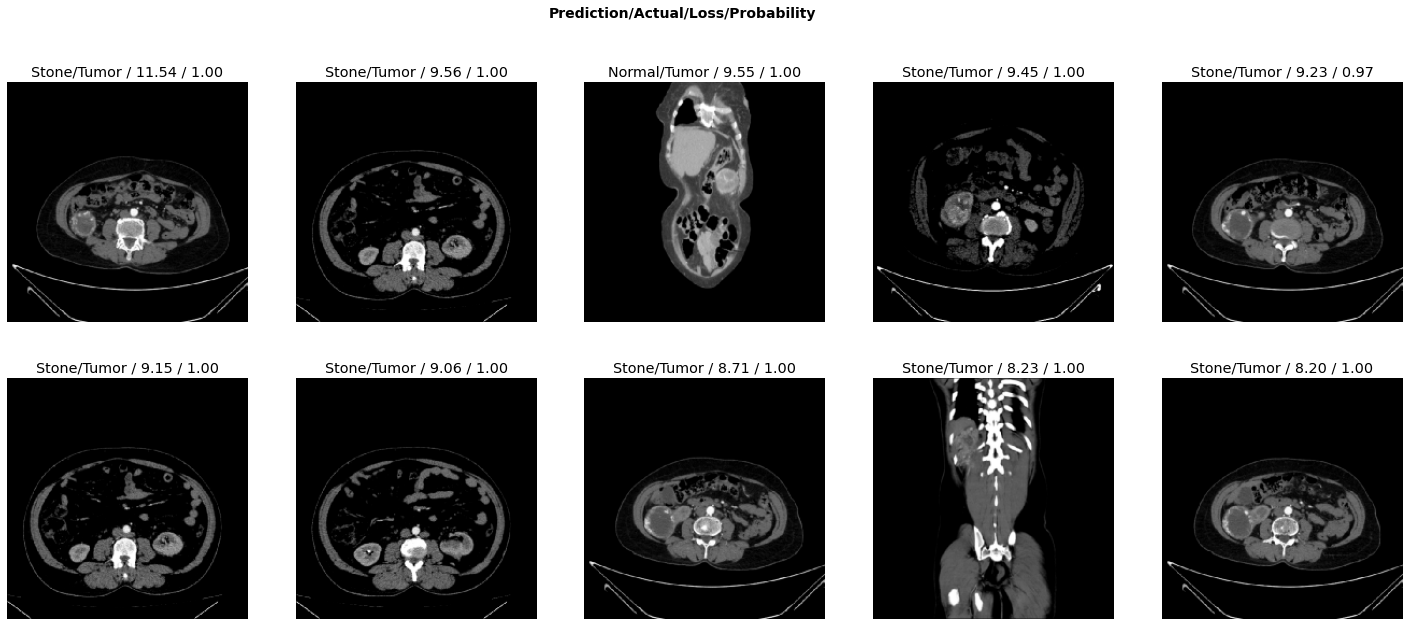

In [ ]:
interp.plot_top_losses(10, nrows=2, figsize = (25,10))

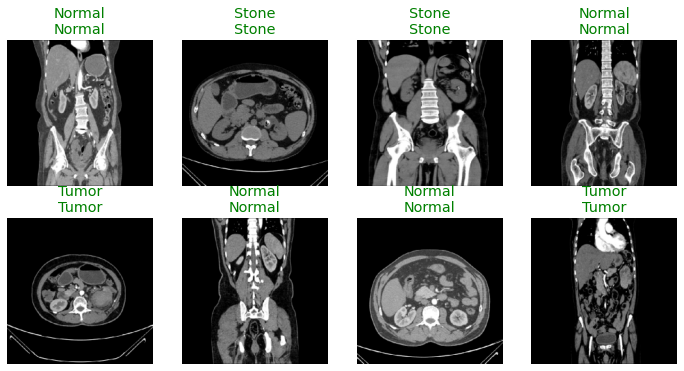

In [ ]:
learn1.show_results(max_n=8, figsize=(12,6))

# XAI image explanation

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 575 kB 4.4 MB/s 


In [ ]:
preds = learn1.get_preds()
pred_class = preds[0].max(1).indices
tgts = preds[1]

for i, name in enumerate(dls.train.vocab):
    idx = torch.nonzero(tgts==i)
    subset = (tgts == pred_class)[idx]
    acc = subset.squeeze().float().mean()
    print(f'{name}: {acc:.1%}')

Normal: 99.0%
Stone: 100.0%
Tumor: 79.6%


In [ ]:
import tensorflow
import shap
import matplotlib.pyplot as pl
from shap.plots import colors

# pull a sample of our data 
batch = dls_test.one_batch()

# specify how many images to use when creating the background distribution
num_samples = 40
explainer = shap.GradientExplainer(
    learn1.model, batch[0][:num_samples]
)

# calculate shapely values
shap_values = explainer.shap_values(
    batch[0][num_samples:]
)

In [ ]:
i = 0
for idx, x in enumerate(batch[0][num_samples:]):
  i+=1
  print(idx)

In [ ]:
!mkdir 'SHAP_CTdataset_new'

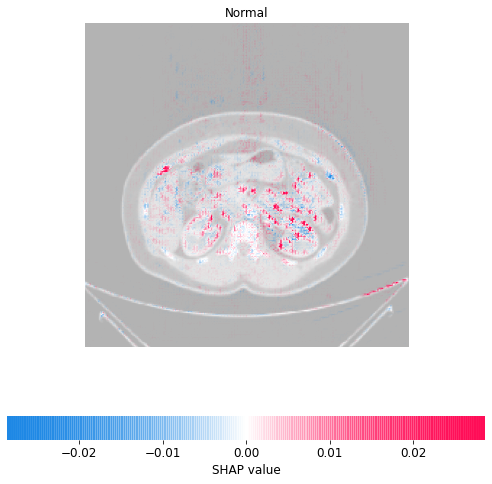

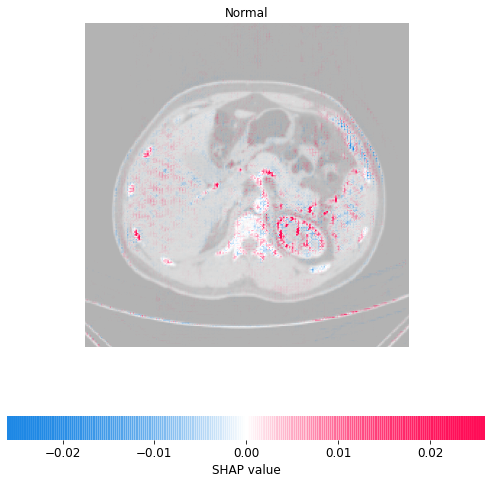

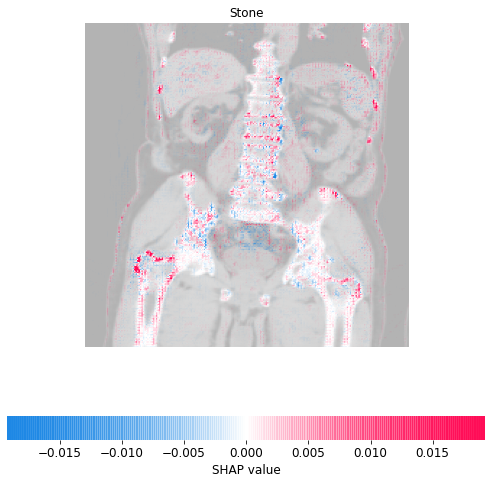

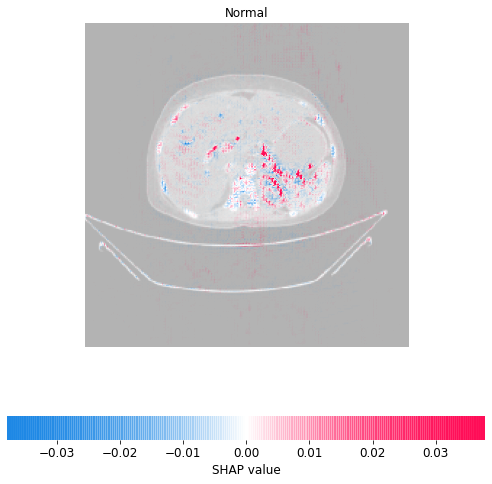

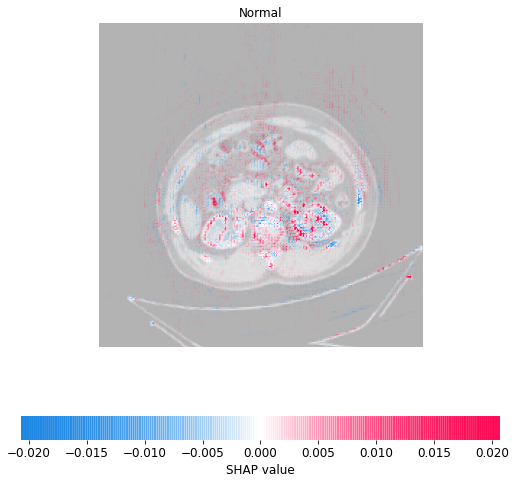

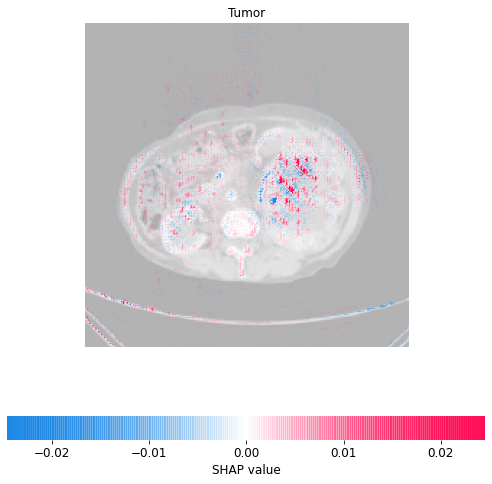

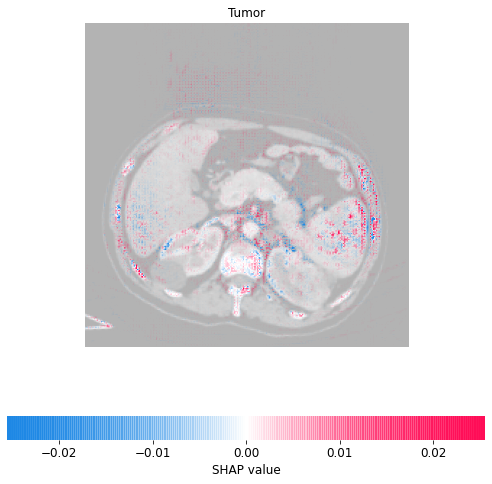

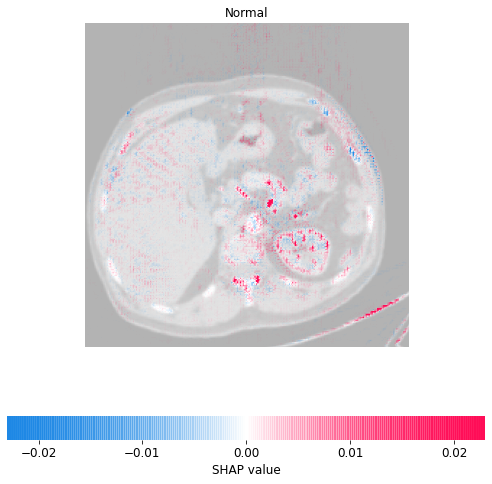

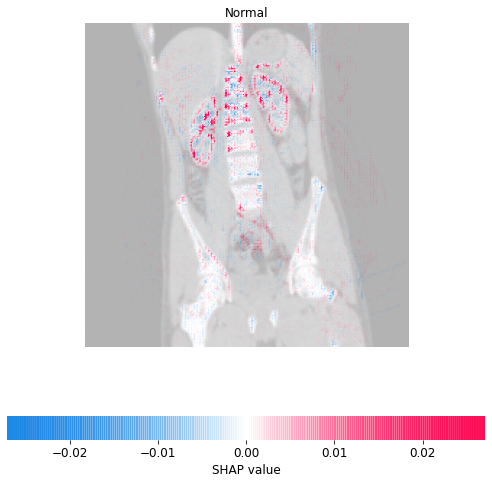

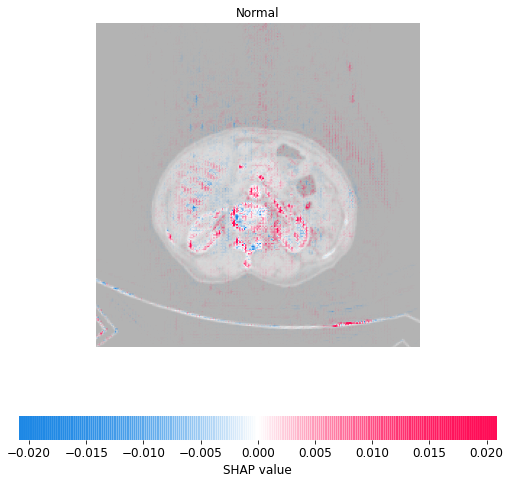

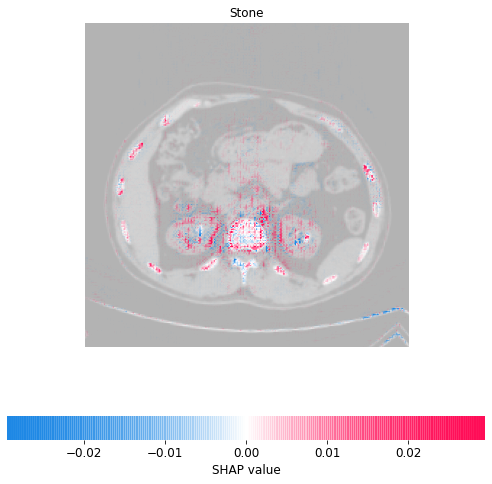

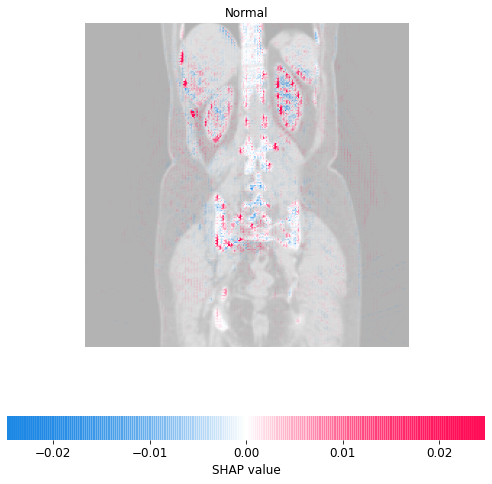

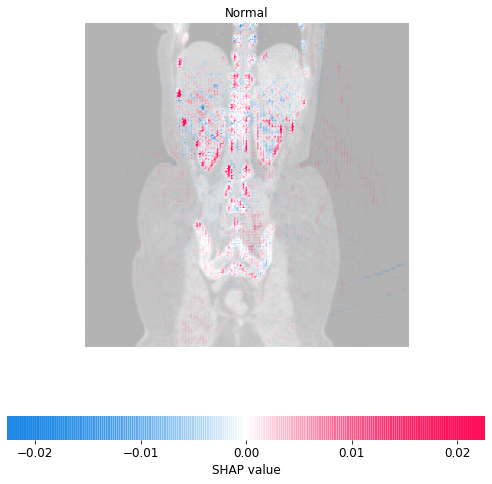

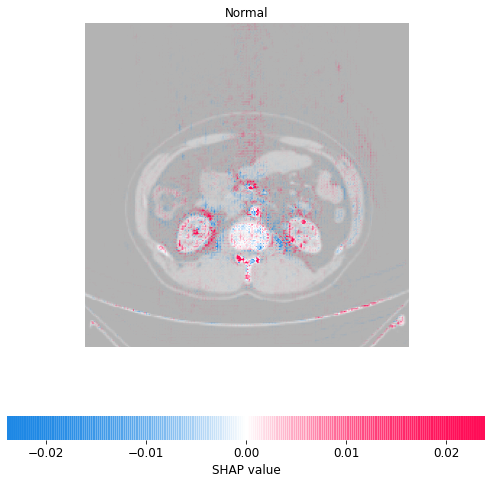

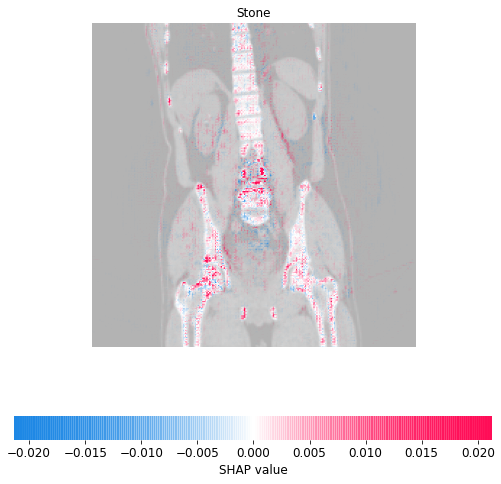

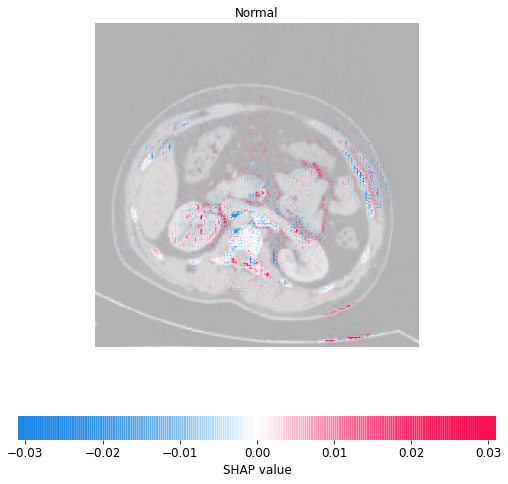

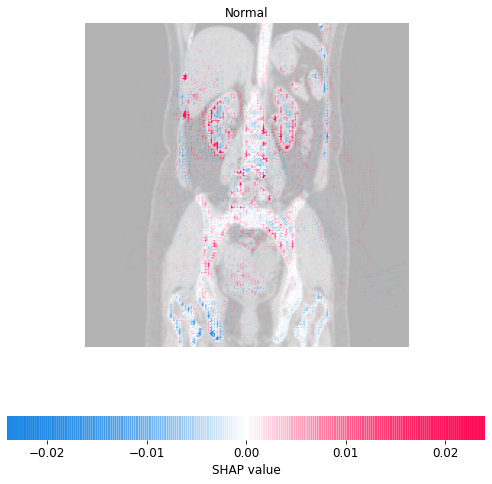

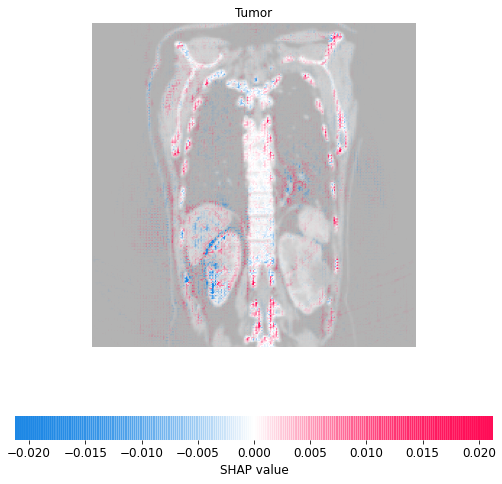

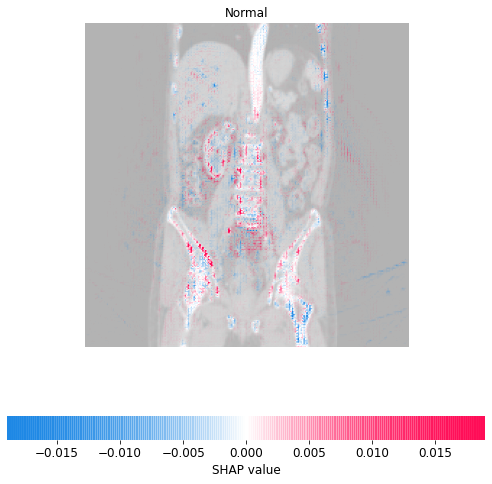

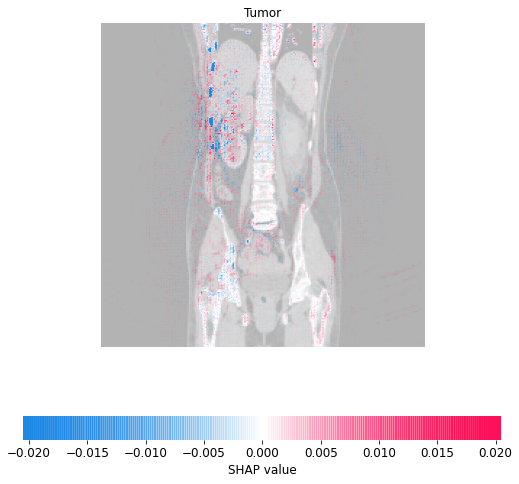

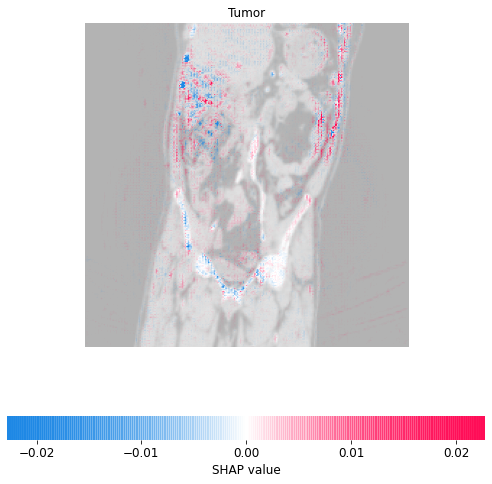

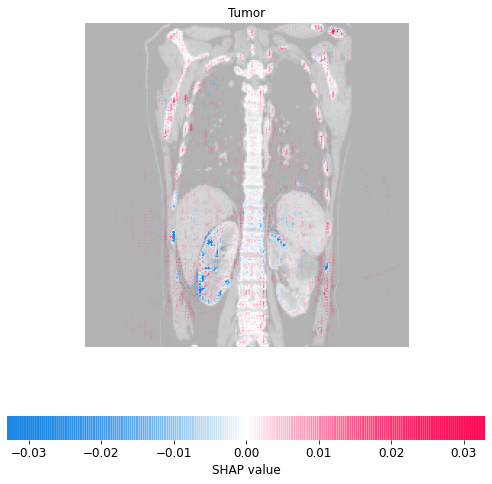

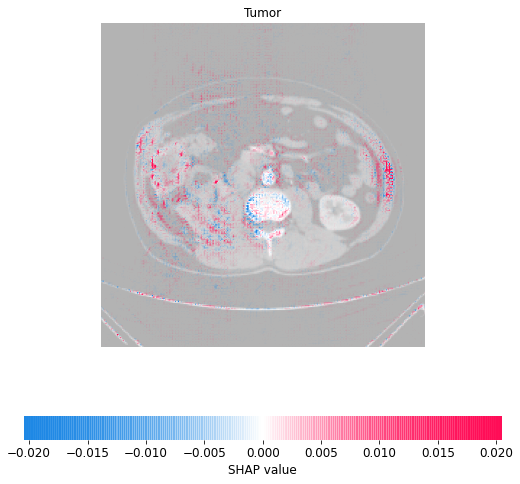

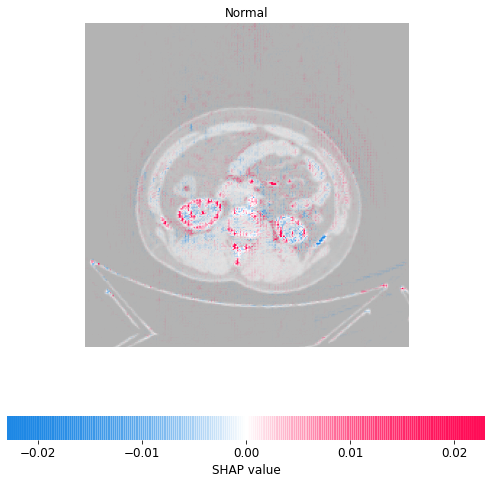

In [ ]:
# Create SHAP mask for explanation
for idx, x in enumerate(batch[0][num_samples:]):
  x = x.cpu() 
  label = dls.train.vocab[batch[1][num_samples:]][idx]
  sv_idx = list(dls.train.vocab).index(label)

  # plot our explanations
  fig, axes = pl.subplots(figsize=(7, 7))
  # pl.show()
  # make sure we have a 2D array for grayscale
  if len(x.shape) == 3 and x.shape[2] == 1:
      x = x.reshape(x.shape[:2])
  if x.max() > 1:
      x /= 255.

  # get a grayscale version of the image
  x_curr_gray = (
      0.2989 * x[0,:,:] +
      0.5870 * x[1,:,:] +
      0.1140 * x[2,:,:]
  )
  x_curr_disp = x

  abs_vals = np.stack(
      [np.abs(shap_values[sv_idx][idx].sum(0))], 0
  ).flatten()
  max_val = np.nanpercentile(abs_vals, 99.9)

  label_kwargs = {'fontsize': 12}
  axes.set_title(label, **label_kwargs)

  sv = shap_values[sv_idx][idx].sum(0)
  axes.imshow(
      x_curr_gray,
      cmap=pl.get_cmap('gray'),
      alpha=0.3,
      extent=(-1, sv.shape[1], sv.shape[0], -1)
  )
  im = axes.imshow(
      sv,
      cmap=colors.red_transparent_blue, 
      vmin=-max_val, 
      vmax=max_val
  )
  axes.axis('off')

  fig.tight_layout()

  cb = fig.colorbar(
      im, 
      ax=np.ravel(axes).tolist(),
      label="SHAP value",
      orientation="horizontal"
  )
  cb.outline.set_visible(False)
  pl.savefig("SHAP_CTdataset_new/shap_fig_"+str(idx)+".png")
  pl.show()
  